# _(Mi, et. al., 2017)_ STP for Working Memory Capacity

Implementation of the paper:

- Mi, Yuanyuan, Mikhail Katkov, and Misha Tsodyks. "Synaptic correlates of working memory capacity." Neuron 93.2 (2017): 323-330.


In [8]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [9]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')
bm.enable_x64()

In [10]:
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [11]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
Ts_interval = 0.070  # the time interval between the consequent external input [s]
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

In [12]:
# the excitatory cluster model and the inhibitory pool model

class WorkingMemoryModel(bp.dyn.DynamicalSystem):
  def __init__(self, **kwargs):
    super(WorkingMemoryModel, self).__init__(**kwargs)

    # variables
    self.u = bm.Variable(bm.ones(cluster_num) * U)
    self.x = bm.Variable(bm.ones(cluster_num))
    self.h = bm.Variable(bm.zeros(cluster_num))
    self.r = bm.Variable(self.log(self.h))
    self.input = bm.Variable(bm.zeros(cluster_num))
    self.inh_h = bm.Variable(bm.zeros(1))
    self.inh_r = bm.Variable(self.log(self.inh_h))

  def log(self, h):
    # return alpha * bm.log(1. + bm.exp(h / alpha))
    return alpha * bm.log1p(bm.exp(h / alpha))

  def update(self, tdi):
    uxr = self.u * self.x * self.r
    du = (U - self.u) / tau_f + U * (1 - self.u) * self.r
    dx = (1 - self.x) / tau_d - uxr
    dh = (-self.h + J_EE * uxr - J_EI * self.inh_r + self.input + Ib) / tau
    dhi = (-self.inh_h + J_IE * bm.sum(self.r) + Iinh) / tau_I
    self.u += du * tdi.dt
    self.x += dx * tdi.dt
    self.h += dh * tdi.dt
    self.inh_h += dhi * tdi.dt
    self.r[:] = self.log(self.h)
    self.inh_r[:] = self.log(self.inh_h)
    self.input[:] = 0.

In [13]:
dt = 0.0001  # [s]
# the external input
I_inputs = bm.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
  t_start = (Ts_interval + Ts_duration) * i + Ts_interval
  t_end = t_start + Ts_duration
  idx_start, idx_end = int(t_start / dt), int(t_end / dt)
  I_inputs[idx_start: idx_end, i] = Iext_train

In [14]:
# running
runner = bp.dyn.DSRunner(WorkingMemoryModel(),
                         inputs=['input', I_inputs, 'iter'],
                         monitors=['u', 'x', 'r', 'h'],
                         dt=dt)
runner(duration)

  0%|          | 0/25000 [00:00<?, ?it/s]

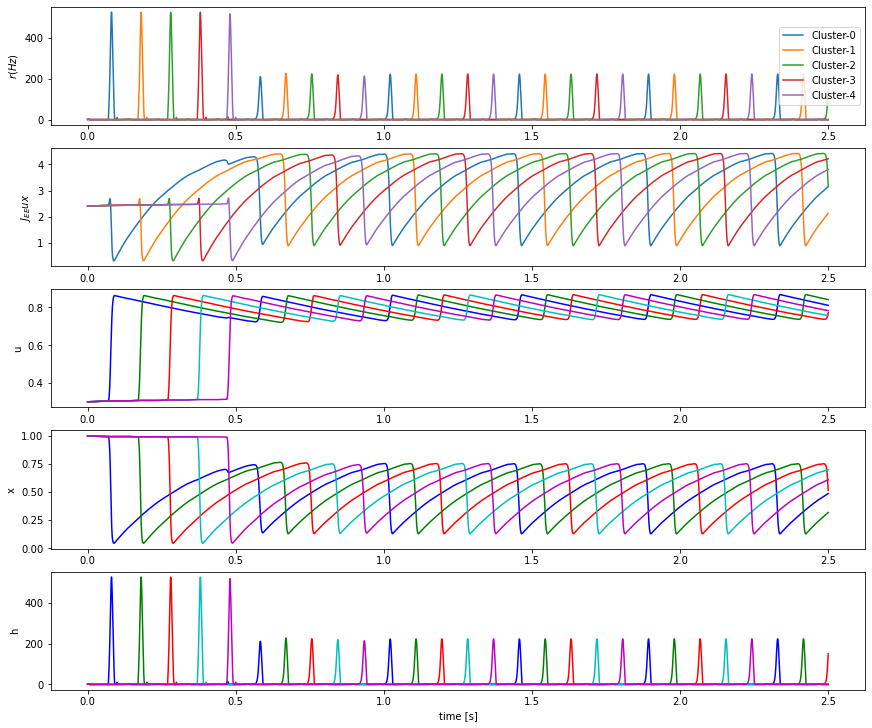

In [16]:
# visualization
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
  plt.plot(runner.mon.ts, runner.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * runner.mon.u * runner.mon.x
for i in range(stimulus_num):
  plt.plot(runner.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
  plt.plot(runner.mon.ts, runner.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
  plt.plot(runner.mon.ts, runner.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
  plt.plot(runner.mon.ts, runner.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()